In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# 데이터 뜯어 보기

## 전체적 경향
- 본 데이터는 10분마다 측정한 데이터임
- 일일 누적 일사량이 144개마다 0으로 리셋되는 것을 보아 0시 0분부터 측정된 데이터라 유추할 수 있음
- X14, X16, X19는 train, test에서 모두 0 -> 삭제
- 기온 변수가 있는데 이는 대기 온도를 뜻하고 온도는 따뜻함과 차가움의 정도를 나타냄

## 일일 누적 일사량, 강수량
- 10분 간 데이터와 30분 간 누적 데이터를 추출

## 풍향
- 0부터 360까지라 각도를 나타냄. 사인 함수로 변형

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import random

np.random.seed(123)
random.seed(123)

train = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
test = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
test.index = test.id
sample_sub = pd.read_csv('/gdrive/My Drive/Data/sample_submission1.csv')
df = pd.concat([train,test],axis=0,sort=False)
df.drop(['X14','X16','X19'],axis=1, inplace=True)
for col in df.columns:
  col_type = df[col].dtypes
  if str(col_type)[:3] == 'int':
    df[col] = df[col].astype(np.int16)
  else:
    df[col] = df[col].astype(np.float32)

df[["X02", "X03", "X18", "X24", "X26"]] = np.log(df[["X02", "X03", "X18", "X24", "X26"]]+2)
df_dew = df[["X05","X08","X09","X23","X33"]]
df_dew1 = df[["X01","X06","X22","X27","X29"]]

df_atm = pd.DataFrame()
for col1 in df_dew.columns:
  for col2 in df_dew1.columns:
    df[col1+"-"+col2] = df_dew[col1] - df_dew1[col2]
# df.drop(df_dew.columns,axis=1,inplace=True)
# df.drop(df_dew1.columns,axis=1,inplace=True)

df_wind = pd.DataFrame()
df_sun_rain = pd.DataFrame()
df_wind[["X13_si","X15_si","X17_si","X25_si","X35_si"]] =  np.sin(np.pi*df[["X13","X15","X17","X25","X35"]]/360)
df_wind[["X13_cos","X15_cos","X17_cos","X25_cos","X35_cos"]] =  np.cos(np.pi*df[["X13","X15","X17","X25","X35"]]/360)
df.drop(["X13","X15","X17","X25","X35"],axis=1, inplace=True)
df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] = df[["X04","X10","X11","X21","X34","X36","X39"]] - df[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0)
df_sun_rain.loc[np.arange(0,df.shape[0],144),["X04","X10","X11","X21","X34","X36","X39"]] = 0
df_sun_rain[["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36_diff","X39_diff"]] = df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] + df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0) + df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(2).fillna(0)
df_sun_rain.loc[np.arange(0,df.shape[0],144),["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36_diff","X39_diff"]] = 0
df_sun_rain.loc[np.arange(1,df.shape[0],144),["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36_diff","X39_diff"]] = 0

df.drop(["X04","X10","X11","X21","X34","X36","X39"],axis=1, inplace=True)
df_sun_rain[["X04", "X10", "X11", "X21", "X34","X36","X39"]] = np.log(df_sun_rain[["X04", "X10", "X11", "X21", "X34","X36","X39"]]+1000)
df_sun_rain[["X04_diff", "X10_diff", "X11_diff", "X21_diff", "X34_diff","X36_diff","X39_diff"]] = np.log(df_sun_rain[["X04_diff", "X10_diff", "X11_diff", "X21_diff", "X34_diff","X36_diff","X39_diff"]]+1000)



y_col = df.loc[:,"Y00":"Y18"].columns
df1 = df[y_col]
df.drop(y_col,axis=1,inplace=True)


minute = (df.id%144).astype(int)
hour= pd.Series((df.index%144/6).astype(int))
min_in_day = 24*6
hour_in_day = 24

minute_sin = np.sin(2*np.pi*minute/min_in_day) 
minute_cos = np.cos(2*np.pi*minute/min_in_day)
hour_sin  = np.sin(2*np.pi*hour/hour_in_day)
hour_cos  = np.cos(2*np.pi*hour/hour_in_day)

df_wind["minute_sin"], df_wind["minute_cos"],df_wind["hour_sin"],df_wind["hour_cos"] = minute_sin, minute_cos, hour_sin, hour_cos
df = pd.concat([df,df_sun_rain,df_wind,df1],axis=1,sort=False)
x_col = df.loc[:,"X00":"X39_diff"].columns
x_col1 = df.loc[:,"X13_si":"hour_cos"].columns
y_col = df.loc[:,"Y00":"Y17"].columns
train = df.iloc[:train.shape[0],:]
test = df.iloc[train.shape[0]:,:]

def standardization(df):
    dfmax = df.max()
    dfmin = df.min()
    norm = (df - dfmin) / (dfmax - dfmin)
    return norm, dfmin, dfmax
train_norm, train_min, train_max = standardization(train[x_col])
test_norm = (test[x_col] - train_min) / (train_max - train_min)

train1 = pd.concat([train_norm, train[x_col1]], axis=1) 
test1  = pd.concat([test_norm, test[x_col1]] , axis=1)

In [2]:
train34 = train[["X00","X01","X33"]]
k = train34["X01"]/train34["X33"]
train34["x"] = k
# train34["x"] = 0.03414*train34["X01"]*100/(273+train34["X00"])
# train34["x1"] = train34["X05"]- train34["X01"]
# train34.describe()
train.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,X00,X01,X02,X03,X05,X06,X07,X08,X09,X12,X18,X20,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X37,X38,X05-X01,X05-X06,X05-X22,X05-X27,X05-X29,X08-X01,X08-X06,X08-X22,X08-X27,X08-X29,X09-X01,X09-X06,X09-X22,X09-X27,...,X04_diff,X10_diff,X11_diff,X21_diff,X34_diff,X36_diff,X39_diff,X13_si,X15_si,X17_si,X25_si,X35_si,X13_cos,X15_cos,X17_cos,X25_cos,X35_cos,minute_sin,minute_cos,hour_sin,hour_cos,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
count,4752.00000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,...,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4.752000e+03,4.752000e+03,4.752000e+03,4.752000e+03,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,432.000000
mean,2375.50000,20.227880,988.620605,1.211875,1.203315,1008.334778,989.004333,21.658070,1008.791016,1008.396179,68.209656,1.164737,71.479156,1001.771912,1008.851196,1.033624,1.152225,1007.554382,22.079247,1000.812073,65.657806,19.846539,20.012960,1009.077148,65.918777,58.178722,19.712812,19.328815,6.560616,0.778976,7.521969,20.169220,19.785166,7.017142,1.235419,7.978400,19.773100,19.389046,6.620975,0.839247,...,6.908113,6.908112,6.908362,6.908115,6.908414,6.908115,6.908112,0.667755,0.678965,0.551893,0.395184,0.640612,0.093031,0.015093,0.065989,0.167740,-0.235794,1.475522e-16,2.455481e-17,-4.866571e-17,-7.378124e-17,21.324190,23.664583,23.623611,24.498959,24.510302,24.165857,22.530672,23.786573,24.016897,22.222801,23.737268,24.649652,23.641897,20.926157,21.319445,21.564468,22.969097,23.381828,26.687500
std,1371.92857,4.707582,3.359913,0.293286,0.268624,3.395032,3.403705,4.377211,3.520309,3.546180,22.278074,0.317074,21.830395,3.367752,3.417631,0.338498,0.349086,3.446481,4.225199,3.390204,21.525688,5.520257,5.271636,3.440681,19.527201,18.368263,0.315294,0.377223,0.107900,0.478957,0.257579,0.557333,0.422937,0.529790,0.561350,0.482086,0.483906,0.565533,0.569563,0.737885,...,0.000438,0.000423,0.000611,0.000442,0.000657,0.000500,0.000433,0.357886,0.317332,0.375982,0.375079,0.314823,0.646128,0.661962,0.741514,0.821693,0.659557,7.071812e-01,7.071812e-01,7.071812e-01,7.071812e-01,4.309412,7.566626,7.423355,3.343435,3.437553,8.589213,7.468754,8.732556,9.832267,9.112313,10.599020,12.214863,8.400088,6.106049,7.066168,6.810126,8.054222,9.275191,6.286621
min,0.00000,8.300000,977.299988,0.693147,0.693147,997.200012,978.099976,11.600000,997.299988,996.299988,16.400000,0.693147,19.700001,990.799988,997.500000,0.693147,0.693147,997.200012,10.300000,989.700012,17.400000,5.300000,5.500000,998.700012,17.500000,17.900000,18.399963,18.200012,6.299988,-1.000000,6.599976,18.399963,18.799988,4.299988,-0.400024,6.799988,18.899963,17.799988,4.799988,-1.100037,...,6.907755,6.907755,6.907755,6.907755,6.907755,6.907755,6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,11.500000,7.000000,7.000000,16.000000,15.500000,7.500000,6.500000,7.500000,7.000000,3.500000,4.000000,3.000000,6.000000,7.500000,7.500000,7.000000,6.000000,7.000000,18.500000
25%,1187.75000,16.900000,986.799988,0.993252,1.029619,1006.500000,987.099976,18.400000,1006.700012,1006.299988,49.500000,0.916291,53.074999,999.900024,1006.900024,0.693147,0.832909,1005.500000,19.

In [0]:
train2 = train1.iloc[:4320,:]
train3 = train1.iloc[4320:,:].reset_index(drop=True)
train_y = train.iloc[:4320,][y_col]
train18 = train.loc[4320:,"Y18"].reset_index(drop=True)

In [26]:
train3

,X00,X01,X02,X03,X05,X06,X07,X08,X09,X12,X18,X20,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X37,X38,X05-X01,X05-X06,X05-X22,X05-X27,X05-X29,X08-X01,X08-X06,X08-X22,X08-X27,X08-X29,X09-X01,X09-X06,X09-X22,X09-X27,X09-X29,X23-X01,X23-X06,X23-X22,X23-X27,X23-X29,X33-X01,X33-X06,X33-X22,X33-X27,X33-X29,X04,X10,X11,X21,X34,X36,X39,X04_diff,X10_diff,X11_diff,X21_diff,X34_diff,X36_diff,X39_diff,X13_si,X15_si,X17_si,X25_si,X35_si,X13_cos,X15_cos,X17_cos,X25_cos,X35_cos,minute_sin,minute_cos,hour_sin,hour_cos
0,0.486726,0.522614,0.205478,0.545151,0.535715,0.512953,0.436019,0.519802,0.511522,0.942331,0.131600,0.860614,0.533678,0.545920,0.316134,0.000000,0.521978,0.467249,0.538859,0.879699,0.456835,0.481752,0.530386,0.828144,0.776333,0.592604,0.428579,0.500051,0.487801,0.370391,0.515148,0.476182,0.545465,0.416669,0.333341,0.333342,0.421064,0.416679,0.382983,0.343760,0.566671,0.560010,0.655183,0.531252,0.625038,0.590900,0.678568,0.538468,0.999797,0.518525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988362,0.400349,0.000000,0.779884,0.056693,0.152123,-0.916363,1.000000,-0.625923,-0.998392,0.000000,1.000000,0.000000,1.000000
1,0.473451,0.517587,0.369316,0.545151,0.535715,0.512953,0.426540,0.519802,0.511522,0.948466,0.028774,0.888747,0.533678,0.545920,0.131517,0.032931,0.521978,0.454148,0.538859,0.864662,0.446043,0.492701,0.530386,0.833126,0.797139,0.629654,0.428579,0.500051,0.487801,0.370391,0.545461,0.476182,0.545465,0.416669,0.333341,0.375022,0.421064,0.416679,0.382983,0.343760,0.600016,0.560010,0.655183,0.531252,0.625038,0.613636,0.678568,0.538468,0.999797,0.518525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363251,0.431299,0.000000,0.751840,0.476392,-0.931691,-0.902209,1.000000,-0.659346,-0.879233,0.043619,0.999048,0.000000,1.000000
2,0.477876,0.517587,0.383317,0.389888,0.540816,0.518133,0.421801,0.524754,0.511522,0.947239,0.000000,0.888747,0.538862,0.545920,0.035195,0.000000,0.521978,0.454148,0.538859,0.855890,0.435252,0.500000,0.530386,0.839352,0.806242,0.666682,0.428579,0.499949,0.512185,0.407419,0.575775,0.476211,0.545465,0.444458,0.370391,0.375022,0.394754,0.388892,0.382983,0.343760,0.600016,0.520020,0.620688,0.531252,0.625038,0.613636,0.642863,0.512817,0.999797,0.518525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.543907,0.000000,0.143493,0.443853,1.000000,-0.839146,1.000000,-0.989651,-0.896099,0.087156,0.996195,0.000000,1.000000
3,0.482301,0.522614,0.354951,0.411187,0.545920,0.518133,0.421801,0.524754,0.516129,0.948466,0.000000,0.896420,0.544042,0.545920,0.000000,0.000000,0.527471,0.449782,0.538859,0.848371,0.438849,0.503650,0.535913,0.839352,0.816645,0.666682,0.457161,0.500051,0.512199,0.444470,0.545461,0.476211,0.522743,0.416686,0.370391,0.374997,0.421064,0.388892,0.382983,0.375002,0.566671,0.520020,0.586215,0.500010,0.625038,0.613636,0.678590,0.512833,1.000000,0.555576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.518027,0.000000,0.000000,0.377841,1.000000,-0.855364,1.000000,1.000000,-0.925871,0.130526,0.991445,0.000000,1.000000
4,0.482301,0.527638,0.293442,0.389888,0.545920,0.518133,0.421801,0.519802,0.520736,0.950920,0.000000,0.895141,0.544042,0.551020,0.000000,0.000000,0.527471,0.445415,0.544042,0.845865,0.435252,0.510949,0.535913,0.839352,0.819246,0.629654,0.457161,0.500051,0.512199,0.407419,0.484852,0.428576,0.500007,0.388898,0.296290,0.374997,0.447373,0.416662,0.404254,0.374983,0.566671,0.560010,0.620688,0.531252,0.624962,0.590914,0.678590,0.512833,1.000000,0.518525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.660002,0.000000,0.000000,0.332161,1.000000,-0.751264,1.000000,1.000000,-0.943223,0.173648,0.984808,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
 
model_sel = ExtraTreesRegressor(n_estimators=100).fit(train1.iloc[4320:,:].reset_index(drop=True), train18)
selector = SelectFromModel(model_sel, prefit=True, max_features=3357)
X_train_sel = pd.DataFrame(selector.transform(train))


ValueError: ignored

In [33]:
X_train_sel

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.061947,0.809816,0.911765,0.647870,0.104317,0.189781,0.743462,0.714302,0.874984,0.0,0.0,0.0,1.000000,1.000000
1,0.044248,0.795092,0.923274,0.662907,0.107914,0.175182,0.744707,0.761909,0.874984,0.0,0.0,0.0,0.999048,1.000000
2,0.048673,0.855215,0.941177,0.677945,0.097122,0.153285,0.744707,0.761880,0.916639,0.0,0.0,0.0,0.996195,1.000000
3,0.048673,0.874847,0.942455,0.699248,0.086331,0.142336,0.747198,0.761909,0.916639,0.0,0.0,0.0,0.991445,1.000000
4,0.039823,0.889571,0.951407,0.713033,0.075540,0.142336,0.753425,0.761880,0.916639,0.0,0.0,0.0,0.984808,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,0.513274,0.968098,0.895141,0.908521,0.446043,0.496350,0.806974,0.476182,0.375022,0.0,0.0,0.0,0.976296,0.965926
4748,0.513274,0.971779,0.900256,0.926065,0.446043,0.500000,0.809464,0.476182,0.375022,0.0,0.0,0.0,0.984808,0.965926
4749,0.504425,0.975460,0.909207,0.912281,0.449640,0.500000,0.815691,0.476211,0.374997,0.0,0.0,0.0,0.991445,0.965926
4750,0.491150,0.975460,0.918159,0.911028,0.446043,0.503650,0.818182,0.476182,0.374997,0.0,0.0,0.0,0.996195,0.965926


In [16]:
train1.shape

(4752, 78)

In [29]:
for column in train1.columns:
    print('{} : {}'.format(column,round(train1[column].var(),6),2))

X00 : 0.043389
X01 : 0.028507
X02 : 0.026305
X03 : 0.038958
X05 : 0.030004
X06 : 0.031102
X07 : 0.043036
X08 : 0.030371
X09 : 0.026706
X12 : 0.07472
X18 : 0.034967
X20 : 0.077932
X22 : 0.030448
X23 : 0.030405
X24 : 0.05962
X26 : 0.055515
X27 : 0.03586
X28 : 0.034043
X29 : 0.030856
X30 : 0.072763
X31 : 0.03943
X32 : 0.037016
X33 : 0.036135
X37 : 0.059135
X38 : 0.057054
X05-X01 : 0.013636
X05-X06 : 0.011616
X05-X22 : 0.032337
X05-X27 : 0.013647
X05-X29 : 0.009101
X08-X01 : 0.028523
X08-X06 : 0.04056
X08-X22 : 0.014498
X08-X27 : 0.024315
X08-X29 : 0.031879
X09-X01 : 0.04065
X09-X06 : 0.022149
X09-X22 : 0.02503
X09-X27 : 0.024648
X09-X29 : 0.033313
X23-X01 : 0.013964
X23-X06 : 0.013852
X23-X22 : 0.007148
X23-X27 : 0.01473
X23-X29 : 0.036037
X33-X01 : 0.015431
X33-X06 : 0.015633
X33-X22 : 0.013026
X33-X27 : 0.088641
X33-X29 : 0.015571
X04 : 0.001597
X10 : 0.003161
X11 : 0.01009
X21 : 0.001859
X34 : 0.005099
X36 : 0.00079
X39 : 0.002099
X04_diff : 0.003285
X10_diff : 0.003222
X11_diff : 0.03

In [0]:
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in tqdm(range(df.shape[0] - interval)):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target



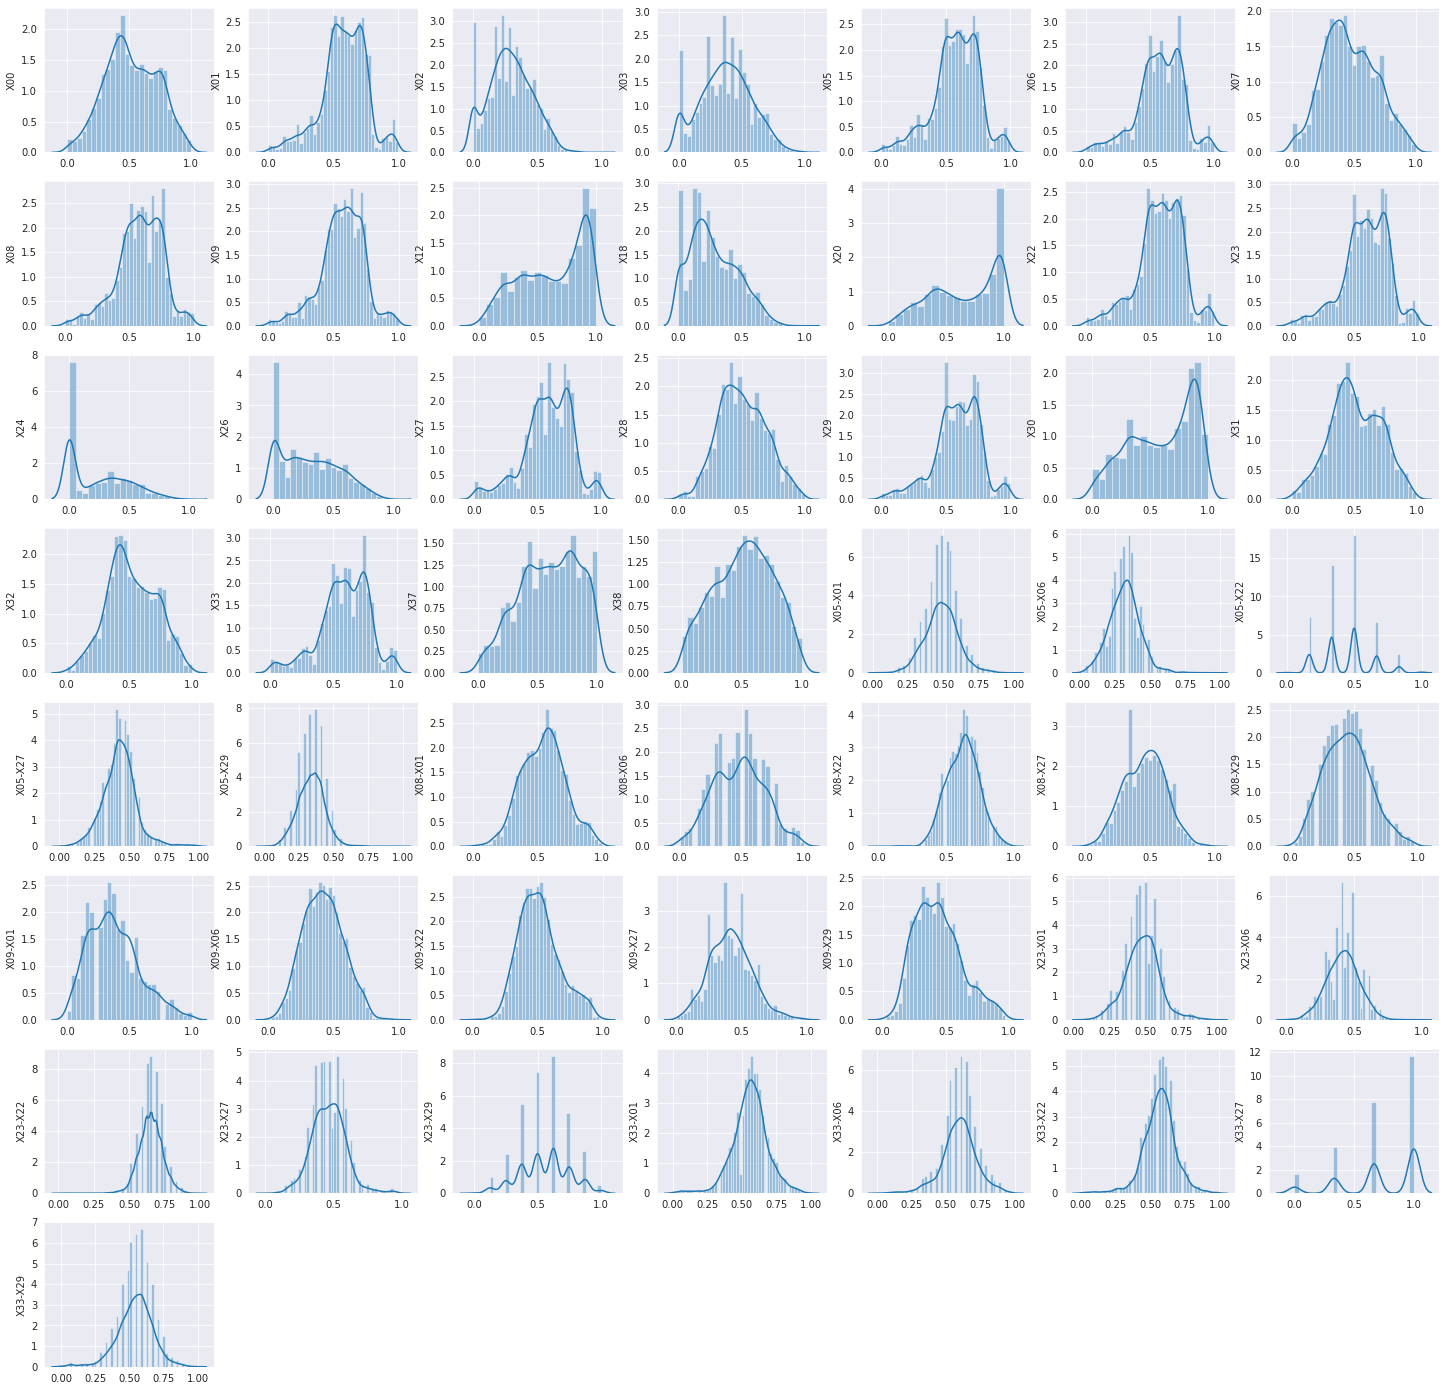

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train2.columns[:50]):
    plt.subplot(8,7,i+1)
    sns.distplot(train2[col])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [46]:
import tensorflow.keras
import tensorflow as tf
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Input, Activation, BatchNormalization
from tensorflow.keras import optimizers

train_reshaped = np.expand_dims(train2 ,axis=1)
train_y_high = train_y
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

def mse_keras(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

model2 = Sequential()
model2.add(LSTM(150, return_sequences= True,input_shape=train_reshaped.shape[-2:]))
model2.add(LSTM(50, return_sequences= False,activation='linear',))
model2.add(Dense(50,activation='linear'))
# model.add(Dense(50,activation='linear'))
model2.add(Dense(18,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model2.compile(optimizer=adam, loss='mse', metrics=[mse_keras])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1, 150)            137400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                40200     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 18)                918       
Total params: 181,068
Trainable params: 181,068
Non-trainable params: 0
_________________________________________________________________


In [31]:
epochs = 100
batch_size = 48
epoch_size = train2.shape[0]

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss')

ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model1_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='loss', verbose=0, save_best_only=True, mode='min')

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e-3, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)
model2.fit(train_reshaped, train_y_high, batch_size=48, epochs=144, shuffle=False,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor = 0.1, patience = 10, min_lr = 3e-5,
                                      verbose = 1),early_stop],validation_split=0.1)

ERROR! Session/line number was not unique in database. History logging moved to new session 60
Epoch 1/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6831 - mse_keras: 1.4980 - val_loss: 2.2847 - val_mse_keras: 2.0951 - lr: 1.3474e-04
Epoch 2/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6788 - mse_keras: 1.4935 - val_loss: 2.3017 - val_mse_keras: 2.1121 - lr: 1.3474e-04
Epoch 3/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6747 - mse_keras: 1.4892 - val_loss: 2.3142 - val_mse_keras: 2.1238 - lr: 1.3474e-04
Epoch 4/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6706 - mse_keras: 1.4851 - val_loss: 2.3231 - val_mse_keras: 2.1339 - lr: 1.3474e-04
Epoch 5/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6666 - mse_keras: 1.4809 - val_loss: 2.3291 - val_mse_keras: 2.1401 - lr: 1.3474e-04
Epoch 6/144
81/81 [==============================] - 0s 5ms/step - loss: 1.6627 - mse_keras: 1.4770 - val

In [0]:
concat = train1

for column in ['Y11','Y09' ,'Y15', 'Y16']:
    concat = pd.concat([concat, train[column]], axis = 1)
    
concat = concat.head(144 * 30)
melted_concat = pd.melt(concat, concat.columns[:-4])
del melted_concat['variable']

melted_array = melted_concat.to_numpy()

seq_steps = 12

dataset = tf.data.Dataset.from_tensor_slices(melted_array)
dataset = dataset.window(seq_steps, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(12))
dataset = dataset.batch(24).repeat()

def getPatial(batch):
    return (batch[:, :, :-1], batch[:, :, -1])

dataset = dataset.map(getPatial)

In [0]:
def get_model():
    inputs = Input(shape = (seq_steps, 78))
    lstm = LSTM(150)(inputs)
    x = Dense(256, activation = 'linear')(lstm)
    x = Dense(128, activation = 'linear')(x)
    x = Dense(1)(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    # mae or mse
    model.compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = ['mse'])

    return model

In [92]:
# model22 = get_model()
model22.fit(dataset, epochs = 100, steps_per_epoch = melted_array.shape[0] // 24 , callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor = 0.8, patience = 5, min_lr = 1e-5,
                                      verbose = 1),early_stop])

Epoch 1/100
720/720 [==============================] - 3s 4ms/step - loss: 5.4441 - mse: 5.4474 - lr: 3.2768e-04
Epoch 2/100
720/720 [==============================] - 3s 4ms/step - loss: 5.3707 - mse: 5.3739 - lr: 3.2768e-04
Epoch 3/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1601 - mse: 5.1632 - lr: 3.2768e-04
Epoch 4/100
720/720 [==============================] - 3s 4ms/step - loss: 5.3555 - mse: 5.3587 - lr: 3.2768e-04
Epoch 5/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1176 - mse: 5.1206 - lr: 3.2768e-04
Epoch 6/100
720/720 [==============================] - 3s 4ms/step - loss: 5.2701 - mse: 5.2732 - lr: 3.2768e-04
Epoch 7/100
720/720 [==============================] - 3s 4ms/step - loss: 4.9903 - mse: 4.9933 - lr: 3.2768e-04
Epoch 8/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1630 - mse: 5.1661 - lr: 3.2768e-04
Epoch 9/100
720/720 [==============================] - 3s 4ms/step - loss: 5.0377 - mse: 5.0407 

In [0]:
test_concat = pd.concat([train1, test1], axis = 0)
test_concat = test_concat.to_numpy()

test_ds = tf.data.Dataset.from_tensor_slices(test_concat)
test_ds = test_ds.window(seq_steps, shift = 1, drop_remainder = True)
test_ds = test_ds.flat_map(lambda window: window.batch(12))

test_X = []

for i in test_ds.take(16260):
    test_X.append(i.numpy())
test_X = np.array(test_X[-11520:])

In [0]:
transfer_x = train1.tail(432).to_numpy()
transfer_y = train18.tail(432).to_numpy()

transfer_ds = tf.data.Dataset.from_tensor_slices(transfer_x)
transfer_ds = transfer_ds.window(seq_steps, shift = 1, drop_remainder = True)
transfer_ds = transfer_ds.flat_map(lambda window:window.batch(12))

label_ds = tf.data.Dataset.from_tensor_slices(transfer_y)

model_ds = tf.data.Dataset.zip((transfer_ds, label_ds))
model_ds = model_ds.batch(24).repeat()

In [96]:
ft_hs = model22.fit(model_ds, epochs = , steps_per_epoch = (432 // 24) + 1)

Epoch 1/11
19/19 [==============================] - 0s 5ms/step - loss: 1.7249 - mse: 1.7620
Epoch 2/11
19/19 [==============================] - 0s 4ms/step - loss: 1.5155 - mse: 1.5489
Epoch 3/11
19/19 [==============================] - 0s 4ms/step - loss: 1.7198 - mse: 1.7583
Epoch 4/11
19/19 [==============================] - 0s 5ms/step - loss: 1.3777 - mse: 1.4079
Epoch 5/11
19/19 [==============================] - 0s 4ms/step - loss: 1.1792 - mse: 1.2045
Epoch 6/11
19/19 [==============================] - 0s 4ms/step - loss: 1.1312 - mse: 1.1552
Epoch 7/11
19/19 [==============================] - 0s 4ms/step - loss: 1.0541 - mse: 1.0762
Epoch 8/11
19/19 [==============================] - 0s 4ms/step - loss: 0.9867 - mse: 1.0071
Epoch 9/11
19/19 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 1.0216
Epoch 10/11
19/19 [==============================] - 0s 4ms/step - loss: 0.9085 - mse: 0.9269
Epoch 11/11
19/19 [==============================] - 0s 4ms/step - lo

In [0]:
preds = model22.predict(test_X)

In [0]:
sample_sub["Y18"] = preds
sample_sub.to_csv('/gdrive/My Drive/Data/tem_sample1.csv',index=False)

In [0]:
def high_corr(df, col, ratio):
    Y_corr = df.corr()
    Y_high = Y_corr.loc[:,(Y_corr[col]> ratio)|(Y_corr[col] < -ratio)].columns
    return Y_high
Y_high = high_corr(y_train, "Y18", 0.7)
print(Y_high[:-1])

Index(['X00', 'X07', 'X12', 'X18', 'X20', 'X24', 'X28', 'X30', 'X31', 'X32',
       'X37', 'X38', 'X05-X22', 'X08-X01', 'X08-X06', 'X08-X27', 'X08-X29',
       'X09-X01', 'X23-X29', 'X11', 'X34', 'X11_diff', 'X34_diff',
       'minute_cos', 'hour_cos'],
      dtype='object')


In [0]:
import datetime
from pytz import timezone

submission = pd.DataFrame({'id':range(144*33, 144*113),
                          'Y18':preds.reshape(1, -1)[0]})
time = datetime.datetime.now(timezone('Asia/Seoul')).strftime("%Y%m%dT%H%M")
submission.to_csv('./pred' + time + '.csv', index = False)

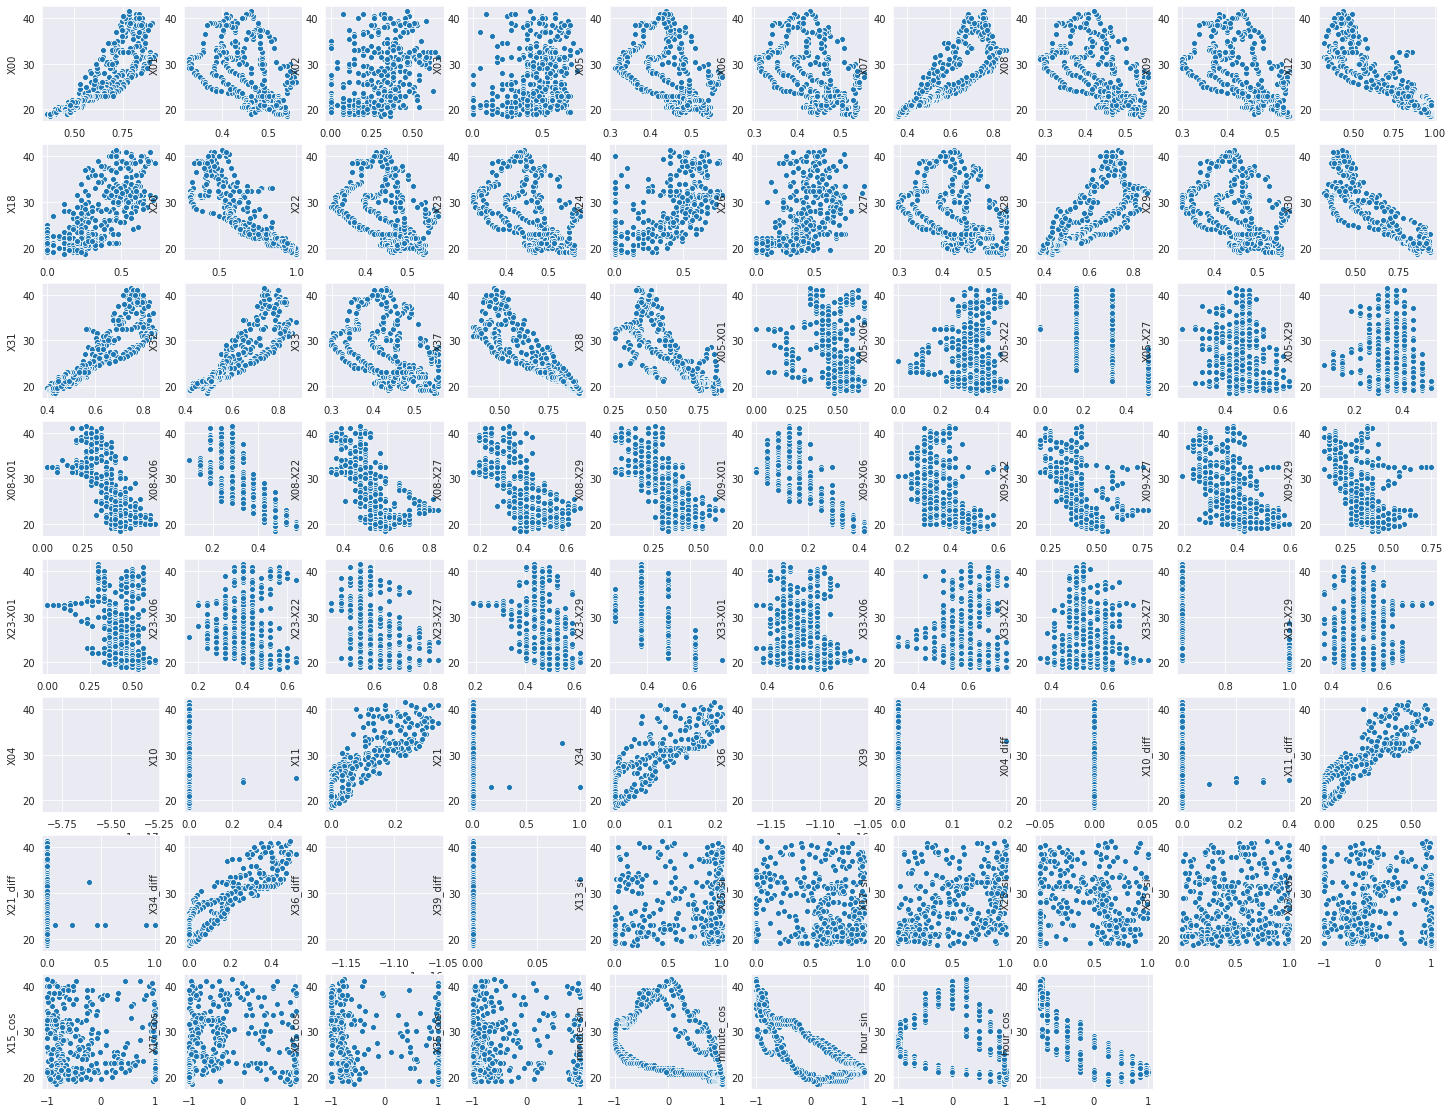

In [0]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train3.columns):
    plt.subplot(10,10,i+1)
    sns.scatterplot(train3[col],train18)
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [0]:
y_train = pd.concat([train3,y017],axis=1,sort=False)

In [0]:
train2.corr()

,X00,X01,X02,X03,X05,X06,X07,X08,X09,X12,X18,X20,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X37,X38,X04,X10,X11,X21,X34,X36,X39,X04_diff,X10_diff,X11_diff,X21_diff,X34_diff,X36_diff,X39_diff,X13_si,X15_si,X17_si,X25_si,X35_si,X13_cos,X15_cos,X17_cos,X25_cos,X35_cos,minute_sin,minute_cos,hour_sin,hour_cos,minute_sin,minute_cos,hour_sin,hour_cos
X00,1.000000,-0.078776,0.198281,0.398218,-0.118630,-0.084701,0.957432,-0.193051,-0.190517,-0.814831,0.532913,-0.832013,-0.091084,-0.119710,0.552667,0.608135,-0.080774,0.942055,-0.083519,-0.780119,0.961906,0.964011,-0.091783,-0.698869,-0.622727,-0.058379,-0.031887,0.655118,-0.067514,0.633991,-0.056378,-0.048533,-0.067188,-0.039931,0.686211,-0.080202,0.679445,-0.065109,-0.057973,0.259586,0.049848,0.466287,0.389618,-0.054887,0.058788,-0.210991,-0.459714,-0.441626,-0.229041,-6.017138e-01,-5.874578e-01,-5.328890e-01,-6.477387e-01,-6.017138e-01,-5.874578e-01,-5.328890e-01,-6.477387e-01
X01,-0.078776,1.000000,-0.142419,-0.230650,0.995949,0.995279,-0.012347,0.987977,0.991503,-0.046603,-0.269929,0.002033,0.996954,0.994786,-0.203859,-0.236648,0.987412,0.010866,0.996241,-0.080374,-0.066743,-0.059669,0.987006,-0.157878,-0.167890,-0.180068,-0.127037,0.025893,-0.156611,0.028877,-0.168863,-0.130249,-0.208538,-0.151163,0.015370,-0.190468,0.019123,-0.194275,-0.153153,0.068607,0.116099,0.009162,-0.153949,0.241888,-0.078882,0.123314,0.100458,0.109211,-0.086953,2.176108e-01,4.611890e-02,2.107634e-01,6.933349e-02,2.176108e-01,4.611890e-02,2.107634e-01,6.933349e-02
X02,0.198281,-0.142419,1.000000,0.397197,-0.150909,-0.131840,0.207564,-0.162767,-0.151371,-0.327319,0.357455,-0.296443,-0.146345,-0.150260,0.428153,0.409995,-0.118306,0.160821,-0.138299,-0.342073,0.219895,0.223358,-0.126880,-0.298720,-0.226036,0.068978,0.091168,0.248036,0.120745,0.253303,0.069393,0.098747,0.073325,0.107174,0.259296,0.135336,0.268901,0.081816,0.102571,0.070855,0.342711,0.205118,0.352828,0.165514,0.127888,0.095075,-0.151647,-0.259597,-0.112050,-2.104224e-01,-1.643741e-01,-1.914247e-01,-1.871490e-01,-2.104224e-01,-1.643741e-01,-1.914247e-01,-1.871490e-01
X03,0.398218,-0.230650,0.397197,1.000000,-0.239234,-0.217443,0.361205,-0.267149,-0.269241,-0.490576,0.499596,-0.457121,-0.229629,-0.233531,0.521872,0.550923,-0.195131,0.338183,-0.217261,-0.466824,0.432780,0.418639,-0.203872,-0.362185,-0.329823,0.056826,0.039815,0.365770,0.078723,0.346603,0.054449,0.046999,0.070029,0.036841,0.382009,0.075845,0.374970,0.072947,0.061123,0.177068,0.141581,0.288111,0.392304,0.170852,0.084141,-0.052734,-0.335137,-0.346678,-0.188419,-4.233952e-01,-3.437995e-01,-3.823828e-01,-3.862213e-01,-4.233952e-01,-3.437995e-01,-3.823828e-01,-3.862213e-01
X05,-0.118630,0.995949,-0.150909,-0.239234,1.000000,0.993939,-0.055566,0.991564,0.989933,-0.019668,-0.283925,0.028491,0.999526,0.997876,-0.220799,-0.256137,0.990091,-0.036053,0.997139,-0.053690,-0.099817,-0.095161,0.990753,-0.127289,-0.137154,-0.186090,-0.135408,0.015852,-0.165334,0.019880,-0.167176,-0.135377,-0.216065,-0.161402,0.004009,-0.200582,0.008421,-0.191796,-0.159409,0.072491,0.119129,-0.008497,-0.169203,0.226584,-0.089236,0.113059,0.105759,0.114721,-0.090787,2.424166e-01,5.217005e-02,2.346383e-01,7.803273e-02,2.424166e-01,5.217005e-02,2.346383e-01,7.803273e-02
X06,-0.084701,0.995279,-0.131840,-0.217443,0.993939,1.000000,-0.011985,0.992926,0.987162,-0.062649,-0.261934,-0.016591,0.994928,0.996266,-0.189450,-0.225193,0.995210,0.013245,0.997859,-0.095802,-0.066500,-0.063464,0.994713,-0.179863,-0.193520,-0.202907,-0.141727,0.024365,-0.180964,0.026928,-0.189232,-0.152656,-0.235624,-0.170342,0.014906,-0.220426,0.018176,-0.217416,-0.178501,0.087467,0.153011,0.015690,-0.140138,0.246295,-0.086163,0.118051,0.083803,0.079210,-0.123922,1.936600e-01,5.693996e-02,1.858301e-01,7.746262e-02,1.936600e-01,5.693996e-02,1.858301e-01,7.746262e-02
X07,0.957432,-0.012347,0.207564,0.361205,-0.055566,-0.011985,1.000000,-0.122611,-0.120445,-0.824198,0.472084,-0.814613,-0.026885,-0.056603,0.519332,0.548802,-0.003901,0.982814,-0.017627,-

In [0]:
# model1.load_weights('/gdrive/My Drive/ckpt2/model2_58_valloss2.75.hdf5')
yt017 = model.predict(np.expand_dims(test1,axis=1))
yt017 = pd.DataFrame(yt017,columns= train_y.columns)
# yt017 = scaler1.transform(yt017)
yt18 = model1.predict(np.expand_dims(yt017[Y_high.tolist()],axis=1))

In [0]:
sample_sub["Y18"] = yt18
sample_sub.to_csv('/gdrive/My Drive/Data/sample3.csv',index=False)

In [0]:
def mse1(y_pred, dataset):
    y_true = dataset.get_label()

    diff = abs(y_true - y_pred)
    less_then_one = np.array([0 if x < 1 else 1 for x in diff])

    y_pred = less_then_one * y_pred
    y_true = less_then_one *y_true
    
    score= mean_squared_error(y_true, y_pred)
    
    return 'score', score, False

y_high_pred = ["Y00","Y01","Y02","Y03","Y04","Y06","Y09","Y10","Y11","Y13","Y15","Y16"]

train3_y = pd.DataFrame()
test_y = pd.DataFrame()
for col in train_y.columns:
  lgb_train = lgb.Dataset(train2, label=train_y[col])

  lgb_param = {
    "objective":"regression",
    "metrics":"mse",
    "learning_rate":0.005,
    'num_leaves': 45,
    'feature_fraction': 0.95, 
    'bagging_fraction': 0.95, 
    'n_jobs' : -1
  }

  print("start "+col)
  cv_result = lgb.cv(
    lgb_param,
    lgb_train,
    num_boost_round=7000,
    nfold=5,
    early_stopping_rounds=10,
    stratified=False,
    verbose_eval=500
  )
  if cv_result["l2-mean"][-1]<0.6:
    print("train start")
    lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l2-mean"])
    )
    train3_y[col] = lgb_model.predict(train3)
    test_y[col] = lgb_model.predict(test1)
  else:
    print("skip")

start Y00
[500]	cv_agg's l2: 0.230058 + 0.0124879
[1000]	cv_agg's l2: 0.0694828 + 0.00391091
[1500]	cv_agg's l2: 0.0617964 + 0.00310231
[2000]	cv_agg's l2: 0.0597759 + 0.00288365
[2500]	cv_agg's l2: 0.0588947 + 0.00286762
[3000]	cv_agg's l2: 0.0583141 + 0.00279075
[3500]	cv_agg's l2: 0.0579295 + 0.00271607
train start
start Y01
[500]	cv_agg's l2: 0.821123 + 0.0200055
[1000]	cv_agg's l2: 0.265484 + 0.00285901
[1500]	cv_agg's l2: 0.223764 + 0.00456229
[2000]	cv_agg's l2: 0.211833 + 0.00543465
[2500]	cv_agg's l2: 0.205624 + 0.00558651
[3000]	cv_agg's l2: 0.20179 + 0.00606266
[3500]	cv_agg's l2: 0.198967 + 0.00621856
[4000]	cv_agg's l2: 0.19696 + 0.00640193
[4500]	cv_agg's l2: 0.195615 + 0.00650133
[5000]	cv_agg's l2: 0.194699 + 0.00665656
[5500]	cv_agg's l2: 0.194013 + 0.00665471
[6000]	cv_agg's l2: 0.193471 + 0.00668997
[6500]	cv_agg's l2: 0.193092 + 0.00666884
[7000]	cv_agg's l2: 0.1927 + 0.00666036
train start
start Y02
[500]	cv_agg's l2: 0.821016 + 0.0229232
[1000]	cv_agg's l2: 0.2779

In [0]:
train2_new = pd.concat([train2,train_y[cols]],axis=1)
train_new = pd.concat([train3,train3_y],axis=1)
test_y.index = test1.index
cols = train3_y.columns
test_new = pd.concat([test1,test_y],axis=1)

In [0]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
def lgb_cv(num_leaves, learning_rate, n_estimators, reg_alpha, reg_lambda, min_split_gain, min_child_weight,min_child_samples, colsample_bytree, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMRegressor(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            min_split_gain= min_split_gain,
            min_child_weight = min_child_weight,
            min_child_samples = int(min_child_samples),
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict(x_valid)
        true = y_valid
        score -= mse_AIFrenz(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

In [0]:
from functools import partial 
from bayes_opt import BayesianOptimization
func_fixed = partial(lgb_cv, x_data=train3, y_data=train18, n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (40, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 0.95),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.419    |  0.8571   |  0.008336 |  21.52    |  0.02935  |  0.02012  |  6.958e+0 |  84.69    |  0.7578   |  0.08924  |
|  2        | -3.43     |  0.881    |  0.00657  |  16.9     |  0.02261  |  0.06669  |  6.357e+0 |  144.5    |  0.2813   |  0.6199   |
|  3        | -3.583    |  0.8883   |  0.004603 |  24.14    |  0.09306  |  0.09489  |  5.751e+0 |  77.65    |  0.6648   |  0.04242  |


KeyboardInterrupt: ignored

In [0]:
!pip install bayesian-optimization

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    params['min_split_gain'], 
    params['min_child_weight'],
    params['min_child_samples'],
    params['colsample_bytree'],
    x_data=train_new, y_data=train18, n_splits=10, output='model')
preds = []
for model in models:
    pred = model.predict(train2_new)
    preds.append(pred)
pred = np.mean(preds, axis=0)



In [0]:
preds = []
for model in models:
    pred1 = model.predict(test_new)
    preds.append(pred1)
pred1 = np.mean(preds, axis=0)

In [0]:
train2_new.drop("Y18",axis=1,inplace=True)
func_fixed = partial(lgb_cv, x_data=train_new, y_data=train18, n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (40, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 0.95),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)

count    4320.000000
mean       24.960568
std         5.847701
min        19.172671
25%        19.793813
50%        22.238366
75%        30.131558
max        39.938281
Name: Y18, dtype: float64

In [0]:
for model in models:
    pred = model.predict(test_new)
    preds.append(pred)
pred = np.mean(preds, axis=0)
train2_new["Y18"] = pred

In [0]:
train_con = pd.concat([train2_new,train_new],axis=0)
yy = train_con["Y18"]
train_con.drop("Y18",axis=1,inplace=True)
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    params['min_split_gain'], 
    params['min_child_weight'],
    params['min_child_samples'],
    params['colsample_bytree'],
    x_data=train_con, y_data=yy, n_splits=10, output='model')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: ignored

In [0]:
sample_sub.isnull().sum()

id     0
Y18    0
dtype: int64

In [0]:
sample_sub["Y18"] = pred1
sample_sub.to_csv('/gdrive/My Drive/Data/tem_sample1.csv',index=False)

In [0]:
train11 = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
train11.describe()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
count,4752.00000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.0,4752.000000,4752.0,4752.000000,4752.000000,4752.0,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4752.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,432.000000
mean,2375.50000,20.227904,988.621107,1.509764,1.453157,1.270223,1008.333902,989.005093,21.658081,1008.790341,1008.394171,1.006734,11.008479,68.209827,161.357639,0.0,174.346654,0.0,161.823864,1.377462,0.0,71.478872,1.138363,1001.773190,1008.850989,0.985059,139.524453,1.369886,1007.554924,22.079040,1000.811932,65.657639,19.846528,20.012984,1009.074747,11.567563,208.400505,1.533817,65.918771,58.178704,1.083123,21.324190,23.664583,23.623611,24.498958,24.510301,24.165856,22.530671,23.786574,24.016898,22.222801,23.737269,24.649653,23.641898,20.926157,21.319444,21.564468,22.969097,23.381829,26.687500
std,1371.92857,4.707570,3.359916,1.071858,0.936151,4.429852,3.395037,3.403714,4.377216,3.520317,3.546180,3.324415,10.873539,22.278053,98.787460,0.0,97.785811,0.0,115.943382,1.155024,0.0,21.830446,4.079039,3.367735,3.417633,1.091314,131.438036,1.240900,3.446475,4.225203,3.390206,21.525699,5.520259,5.271630,3.440669,11.386727,99.580562,5.578607,19.527173,18.368285,4.617366,4.309451,7.566614,7.423344,3.343437,3.437558,8.589213,7.468692,8.732548,9.832279,9.112299,10.599000,12.214870,8.400081,6.106031,7.066149,6.810084,8.054272,9.275172,6.286621
min,0.00000,8.300000,977.300000,0.000000,0.000000,0.000000,997.200000,978.100000,11.600000,997.300000,996.300000,0.000000,0.000000,16.400000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,19.700000,0.000000,990.800000,997.500000,0.000000,0.000000,0.000000,997.200000,10.300000,989.700000,17.400000,5.300000,5.500000,998.700000,0.000000,0.000000,0.000000,17.500000,17.900000,0.000000,11.500000,7.000000,7.000000,16.000000,15.500000,7.500000,6.500000,7.500000,7.000000,3.500000,4.000000,3.000000,6.000000,7.500000,7.500000,7.000000,6.000000,7.000000,18.500000
25%,1187.75000,16.900000,986.800000,0.700000,0.800000,0.000000,1006.500000,987.100000,18.400000,1006.700000,1006.300000,0.000000,0.020000,49.500000,69.225000,0.0,115.600000,0.0,33.875000,0.500000,0.0,53.075000,0.000000,999.900000,1006.900000,0.000000,0.000000,0.300000,1005.500000,19.000000,998.900000,48.075000,16.000000,16.300000,1007.075000,0.030000,155.300000,0.000000,51.500000,44.600000,0.000000,18.000000,17.500000,17.500000,22.000000,22.000000,17.500000,16.500000,17.000000,17.000000,15.500000,15.500000,15.000000,17.000000,16.500000,16.500000,16.500000,16.500000,16.000000,21.000000
50%,2375.50000,19.900000,988.600000,1.300000,1.300000,0.000000,1008.500000,989.100000,21.200000,1008.800000,1008.400000,0.000000,7.690000,72.150000,182.600000,0.0,170.250000,0.0,190.450000,1.000000,0.0,74.200000,0.000000,1001.900000,1008.900000,0.700000,134.150000,1.100000,1007.700000,21.700000,1000.900000,69.400000,19.400000,19.600000,1009.200000,8.210000,240.850000,0.000000,67.300000,59.100000,0.000000,21.000000,22.000000,22.000000,24.500000,24.500000,22.000000,21.000000,21.500000,21.000000,20.000000,20.500000,21.000000,22.000000,19.500000,19.500000,20.000000,21.500000,20.000000,25.000000
75%,3563.25000,24.100000,991.000000,2.100000,2.000000,0.000000,1010.800000,991.600000,24.825000,1011.400000,1010.900000,0.000000,22.190000,89.025000,228.9

In [0]:
test11 = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
test11.describe()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
count,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.0,11520.000000,11520.0,11520.000000,11520.000000,11520.0,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000
mean,10511.500000,25.145625,987.616693,1.401033,1.479436,2.396016,1006.869314,987.839045,26.032352,1007.321424,1006.938741,2.709115,8.311291,79.575564,114.648646,0.0,125.218993,0.0,136.219931,1.354696,0.0,80.689931,2.847092,1000.417891,1007.368984,1.137622,147.054679,1.349800,1005.802595,26.468750,999.435260,76.208698,24.544392,24.519905,1007.319826,8.480451,172.389991,2.266267,79.336875,71.271146,2.332856
std,3325.681885,3.824374,4.624002,1.376209,1.087042,6.382526,4.757237,4.637961,3.513596,4.788943,4.777357,8.494738,8.678047,16.028721,105.976126,0.0,107.245099,0.0,109.632121,1.251191,0.0,17.504181,8.507719,4.712652,4.743564,1.060000,109.343527,1.277034,4.765731,3.527912,4.690173,15.845644,4.040956,4.021288,4.778875,8.997879,109.130854,8.564625,14.861512,15.016123,6.591677
min,4752.000000,15.500000,970.300000,0.000000,0.000000,0.000000,990.000000,971.300000,17.300000,990.500000,989.200000,0.000000,0.000000,29.100000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,30.000000,0.000000,983.700000,990.500000,0.000000,0.000000,0.000000,989.400000,18.700000,982.700000,25.800000,14.200000,15.100000,990.900000,0.000000,0.000000,0.000000,27.500000,22.800000,0.000000
25%,7631.750000,22.300000,985.300000,0.400000,0.700000,0.000000,1004.400000,985.500000,23.300000,1004.900000,1004.500000,0.000000,0.050000,67.300000,21.075000,0.0,23.900000,0.0,29.075000,0.400000,0.0,67.300000,0.000000,998.000000,1004.900000,0.300000,43.300000,0.300000,1003.300000,23.700000,997.100000,64.400000,21.500000,21.400000,1004.800000,0.000000,73.100000,0.000000,68.600000,60.700000,0.000000
50%,10511.500000,25.300000,987.900000,1.100000,1.300000,0.000000,1007.200000,988.100000,26.100000,1007.700000,1007.300000,0.000000,5.800000,83.300000,71.700000,0.0,119.400000,0.0,128.000000,1.000000,0.0,86.400000,0.000000,1000.700000,1007.700000,0.900000,140.400000,1.100000,1006.100000,26.500000,999.700000,79.800000,24.500000,24.500000,1007.600000,5.715000,178.800000,0.000000,82.100000,72.000000,0.000000
75%,13391.250000,27.600000,990.700000,2.000000,2.000000,0.700000,1010.000000,991.000000,28.300000,1010.500000,1010.100000,0.500000,15.680000,94.000000,204.925000,0.0,219.300000,0.0,224.100000,2.100000,0.0,97.100000,1.000000,1003.500000,1010.500000,1.700000,254.800000,2.000000,1008.900000,28.800000,1002.500000,90.200000,27.200000,27.300000,1010.400000,15.860000,261.400000,0.100000,92.725000,84.300000,0.500000
max,16271.000000,36.300000,998.100000,11.000000,10.900000,46.500000,1018.000000,998.500000,36.000000,1018.500000,1017.900000,57.000000,31.250000,98.700000,359.900000,0.0,359.900000,0.0,360.000000,10.300000,0.0,97.900000,64.500000,1011.400000,1018.500000,9.900000,359.900000,11.900000,1016.900000,36.500000,1010.300000,97.200000,35.300000,35.800000,1018.400000,31.640000,359.900000,97.700000,96.800000,95.900000,79.500000
